In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tool import local_max

## Generate nm:px Conversion Ratio

np/px = 241.25 +/- 0.96 [nm/px]


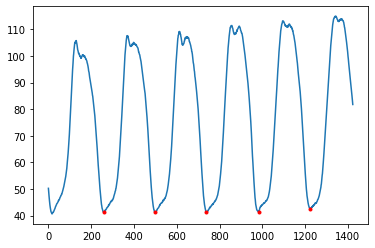

In [ ]:
data = np.genfromtxt("pixel_values_rectangle.txt",delimiter=',', skip_header = 1).T
x_dat = data[0]
y_dat = data[1]

maxes, idx = local_max(-y_dat,N=90)

plt.plot(x_dat,y_dat)
plt.plot(x_dat[idx],y_dat[idx],"r.")
pixel_seperation = np.mean(np.diff(x_dat[idx]))
uncert = np.std(np.diff(x_dat[idx]))

dec = 2
print("np/px =",np.around(pixel_seperation,dec),"+/-",np.around(uncert/2,dec),"[nm/px]")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb45f9e-f9d7-4771-843d-2a6451217511' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>